In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [14]:
file1 = open('2006rts1.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
(len(y))

248

## Sources
- <a href="https://en.wikipedia.org/wiki/Skewness">skewness</a>
- <a href="https://www.investopedia.com/terms/k/kurtosis.asp">kurtosis</a>
- <a href="https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test">Jarque-Bera</a>

In [15]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [16]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_pacf(sample);
    plot_acf(sample);

In [234]:
def ARMA(p, q, y, res_):
    
    df_temp = df = pd.DataFrame(y, columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_
    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    #----------------
    
    res = pd.DataFrame({'Residuals': res_})
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    res_train_2 = res.dropna()
    X_train_ma = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train_ma = res_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ma,y_train_ma)

    theta_ma  = lr.coef_.T
    intercept_ma = lr.intercept_

    res_train_2['Predicted_Values'] = X_train_ma.dot(theta_ma) + intercept_ma
    
#     print(f'pred_y\n', df_train_2['Predicted_Values'])
#     print(f'pred_res\n', res_train_2['Predicted_Values'])
    
    prediction = pd.DataFrame(res_train_2['Predicted_Values'] + df_train_2['Predicted_Values'],columns=['Predicted_Values'])
    
    prediction = prediction.dropna()
    pred = [x for x in y[:max(p,q)]]
    for i in prediction.Predicted_Values:
        pred.append(i)
    
    return pred,theta_ar, theta_ma, intercept_ar + intercept_ma

### Calculate metrics

- <a href="https://www.investopedia.com/terms/r/r-squared.asp">R squared</a>
- <a href="https://en.wikipedia.org/wiki/Residual_sum_of_squares">sum_squared_resid</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">AIC</a>
- <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Duarbin-Watson</a>

In [245]:
def claculate_metrics_model(y, y_pred, p, q, weight, window, params_ar, params_ma, intercept):
    
    y , y_pred = np.array(y), np.array(y_pred)
    
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = r2_score(y, y_pred)
    model_arma_metric['sum_squared_resid'] = sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid']) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_ma'] = params_ma
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [265]:
def weight(res, weight, window):
    
    res_copy = res.copy()
    if weight=='simple':
        wma = res_copy.rolling(window=window).mean()
        
        
    elif weight== 'exponential':
        wma = res_copy.ewm(span=window).mean()
    
    else:
        pass
    
    wma[:window] = res_copy[:window]
    return wma

## ARMA

In [20]:
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 248,
 'mode': 1190.34,
 'mean': 1545.9118951612907,
 'median': 1552.115,
 'variation': 24453.166410563863,
 'skewness': 0.1420579833187732,
 'kurtosis': -0.44372227972289036,
 'jarque-bera': 3.000356221871671,
 'probability': 0.22309042176581806}

In [21]:
y = pd.Series(y)
y.describe()

count     248.000000
mean     1545.911895
std       156.375082
min      1190.340000
25%      1429.807500
50%      1552.115000
75%      1641.837500
max      1921.920000
dtype: float64

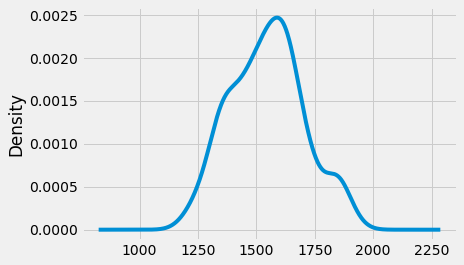

In [22]:
y.plot(kind='kde')

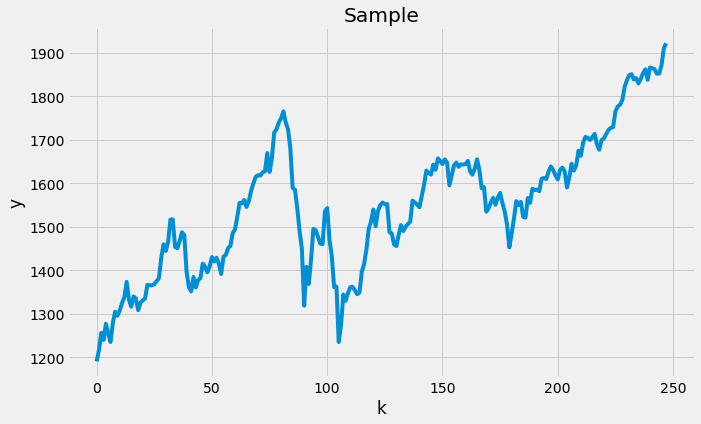

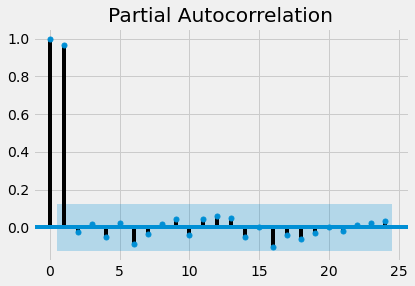

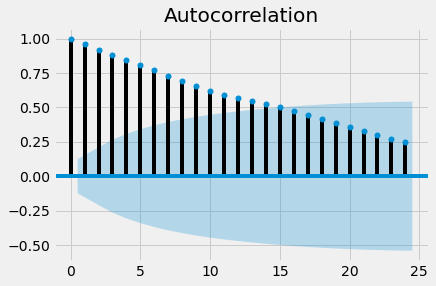

In [23]:
calculate_metrics_sample(y)
show_plots(y)

- [How to choose parameters for ARMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html)

## ARMA is built by residual 

In [29]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(y, order=(15,0))
model_fit = model.fit()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  248
Model:                    ARMA(15, 0)   Log Likelihood               -1184.193
Method:                       css-mle   S.D. of innovations             28.393
Date:                Sat, 24 Oct 2020   AIC                           2402.386
Time:                        12:37:13   BIC                           2462.114
Sample:                             0   HQIC                          2426.430
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1552.7038    190.810      8.137      0.000    1178.722    1926.686
ar.L1.y        1.0670      0.063     16.847      0.000       0.943       1.191
ar.L2.y       -0.0282      0.092     -0.307      0.7

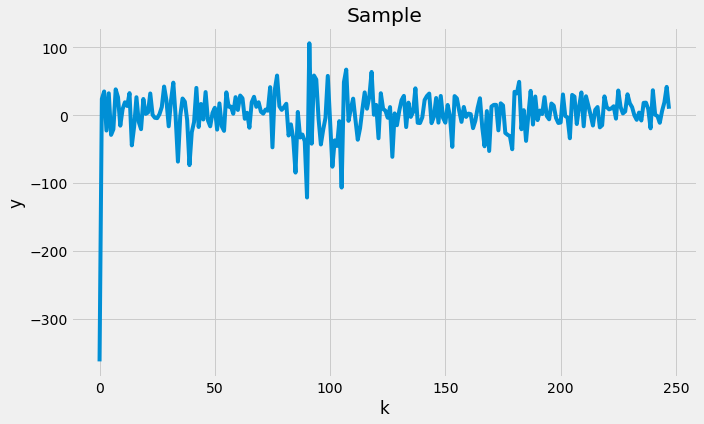

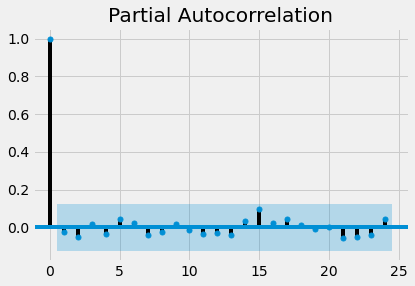

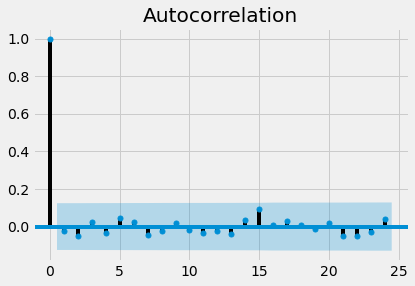

In [30]:
res =  model_fit.resid
show_plots(res)

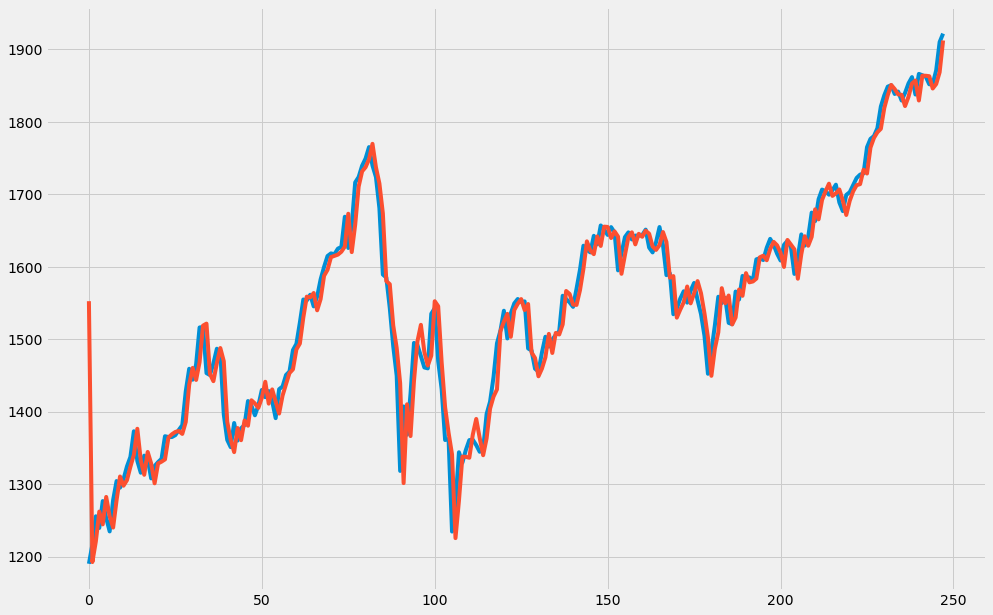

In [36]:
plt.figure(figsize= (15,10))

plt.plot(y)
plt.plot(np.array(model_fit.predict()))

In [272]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model = []

In [273]:
p, q = 15,15

mv5_simple = weight(res, weight='simple',window=5)
mv10_simple = weight(res, weight='simple',window=10)
mv5_epx = weight(res, weight='exponential',window=5)
mv10_epx = weight(res, weight='exponential',window=10)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple, mv5_simple)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple, mv10_simple)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_epx, mv5_epx)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_epx, mv10_epx)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)


In [274]:
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((15, 15)) simple:5",0.946184,325047,3207.55,1.63134,"[[1.0673886970033408], [-0.01875530964728571],...","[[0.9477373038469733], [-0.0009911398697976367...",[18.18355302696531]
1,"ARMA((15, 15)) simple:10",0.946007,326114,3208.36,1.64737,"[[1.0635555973151318], [-0.0258676226215048], ...","[[0.9737728645659902], [-0.05723077297756982],...",[19.4890268218569]
2,"ARMA((15, 15)) exponential:5",0.946339,324110,3206.83,1.63641,"[[1.2263942279885789], [-0.11113181959323139],...","[[0.6626106329828632], [-0.005780426313650512]...",[16.029452210873274]
3,"ARMA((15, 15)) exponential:10",0.946082,325660,3208.02,1.65108,"[[1.108223522867955], [-0.037690616758961466],...","[[0.8189056542621873], [-0.007008096472825515]...",[17.800663377218303]


In [289]:
def show_prediction(y, y_pred, name):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y)
    plt.plot(y_pred)

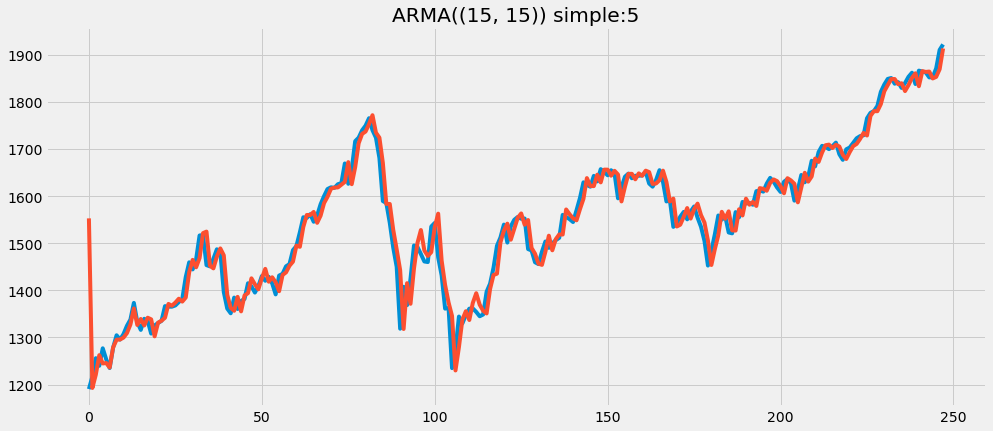

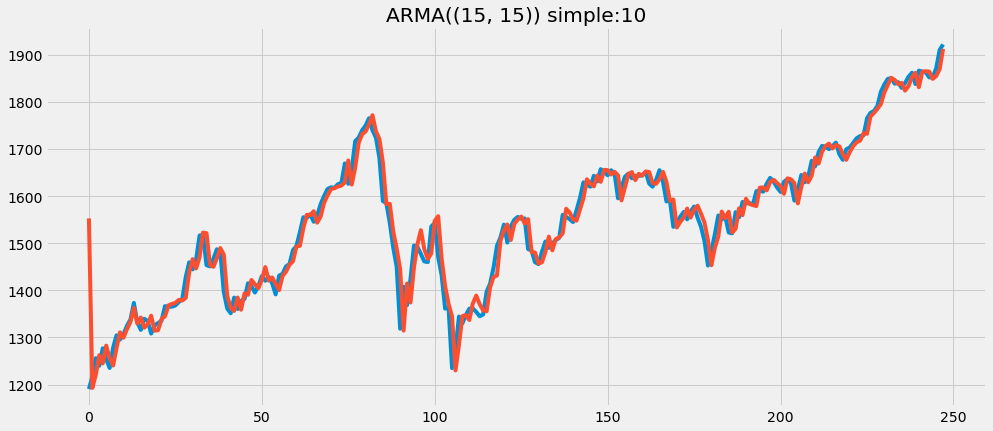

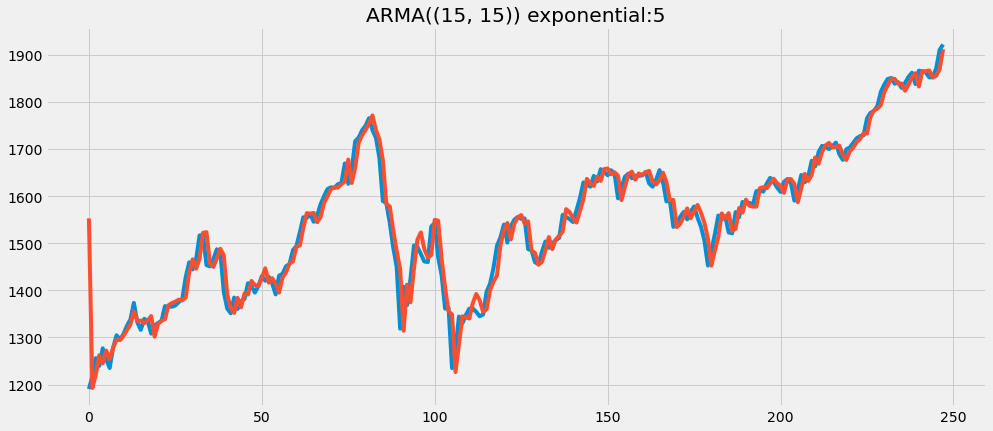

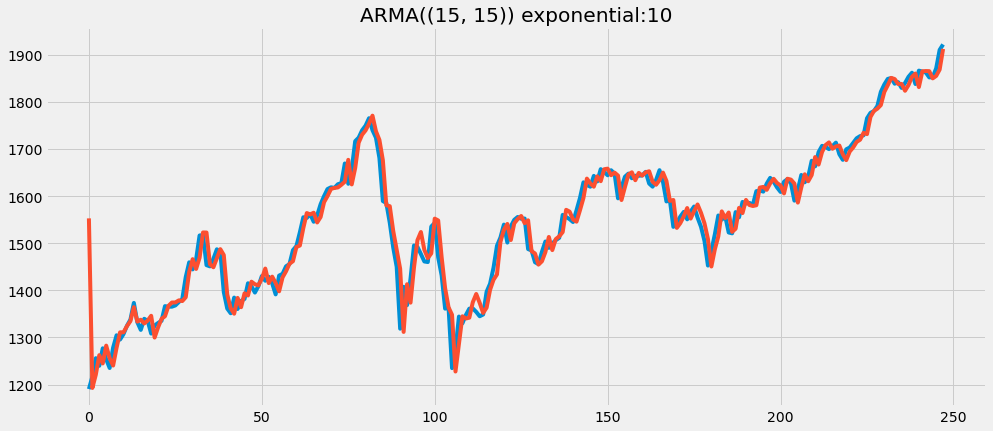

In [290]:
for name, y_pred in zip(models_metrics.name, predictions_model):
    show_prediction(y, y_pred, name)

## 2. Побудова АРКС(p,q) коли КС будується по вихідному сигналу у